### Colab Pro 의 V100 gpu 환경에서 진행하였습니다.

In [ ]:
!nvidia-smi

Sat May 29 14:35:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## pre processing에 필요한 libaray 및 huggingface의 transformer 설치

In [ ]:
# !pip install kss
# !pip install git+https://github.com/haven-jeon/PyKoSpacing.git
# !pip install git+https://github.com/ssut/py-hanspell.git
# !pip install transformers

# EDA (Exploratory Data Analysis)

  ## Data Processing
    - EDA를 통해 모델 학습에 필요하지 않다고 생각되는 점들을 제거, 수정해주었습니다.
      1. 불필요한 문장 부호나 자소 단위 문자 제거 
      2. 반복되는 단어 제거 후 한 단어만 사용
      3. 긴 공백 제거
      4. 띄어쓰기를 문법에 맞게 수정
      5. 맞춤법 검사
      6. 리뷰의 문장을 구분하기 위해 문장 구분 후 마침표 표시
      7. 중복 데이터 제거
        - 중복된 리뷰, 평점을 가진 데이터를 하나만 남기고 제거해주었습니다.
        - 리뷰 내용이 같지만 평점이 다른 데이터들은 제거 후 학습에 사용하지 않았습니다.
    
    => 결과적으로 시간이 너무 오래 걸려 5번 맞춤법 검사는 하지 못하였습니다.
  ## Train Data Sampling
    - 너무 많은 학습 데이터를 전부 학습시키기 어려워서 전체 train data 중 class 분포를 고려한 90000개의 data를 sampling 하여 사용하였습니다.
  ## Tokenizer Max Length
    - 각 data의 length에 대한 histogram을 그려보았습니다. 그리고 대부분의 data가 50보다 작은 length를 가지고 있기 때문에 tokenizer의 max length를 50으로
     설정하여 학습에 사용하였습니다.
  ## Zero length data
    - length가 0인 data가 존재하였고, 이 data들의 label 분포를 확인한 결과, 10인 경우가 가장 많아서 학습에서 제외시킨 후 length가 0인 data는 전부 10으로
     예측하도록 하였습니다.
  ## Class Imbalance Problem
    - 각 class 별 분포를 확인한 결과 class 10의 data가 다른 class와 비교하여 과하게 많이 분포하였습니다. 따라서 그대로 사용할 경우 class 10으로 model이
     overfitting 될 것을 우려하여 각 class 별로 같은 수의 data를 sampling하여 사용하거나 학습 과정에서 imbalance sampler를 사용하여 해결하려 하였습니다.
    - 하지만 결과적으로 class의 imbalance 분포가 존재하는 것이 CV와 LB 모두에서 더 높은 score를 보여 최종 결과에선 사용하지 않았습니다.

In [ ]:
import re
import kss
import csv
import gzip
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import Counter
from pykospacing import Spacing
from hanspell import spell_checker

from sklearn.model_selection import StratifiedKFold

In [ ]:
def data_load(path):
    data = []
    with open(path, 'r') as f:
        line = f.readline()
        while line:
            data.append(line.rstrip())
            line = f.readline()
    return data

In [ ]:
class cfg:
    data_dir = '/content/drive/MyDrive/pjh-algorima'
    tr_data_dir = f'{data_dir}/dataset/train_data'
    tr_label_dir = f'{data_dir}/dataset/train_label'
    va_data_dir = f'{data_dir}/dataset/valid_data'
    va_label_dir = f'{data_dir}/dataset/valid_label'
    te_data_dir = f'{data_dir}/dataset/test_data'
    submission_path = f'{data_dir}/dataset/sample_submission.csv'
    save_result_path = f'{data_dir}/result'
    save_path = f'{data_dir}/model'

In [ ]:
train_data = data_load(cfg.tr_data_dir)
train_label = data_load(cfg.tr_label_dir)
valid_data = data_load(cfg.va_data_dir)
valid_label = data_load(cfg.va_label_dir)
test_data = data_load(cfg.te_data_dir)

In [ ]:
print(f'Number of Train data : {len(train_data)}')
print(f'Number of Train label : {len(train_label)}')
print(f'Number of Valid data : {len(valid_data)}')
print(f'Number of Valid label : {len(valid_label)}')
print(f'Number of Test data : {len(test_data)}')

In [ ]:
# train data를 class 분포를 고려하여 90000개 sample만 사용

split_fold = StratifiedKFold(n_splits=9000000//90000)
_, train_index = next(split_fold.split(list(range(len(train_data))), train_label))

In [ ]:
train_data = [train_data[idx] for idx in train_index]
train_label = [train_label[idx] for idx in train_index]

In [ ]:
# train data를 class 별 동일한 수로 각 9000개 sample만 사용
train_dataset = {}
for data, label in zip(train_data, train_label):
    if not label in train_dataset.keys():
        train_dataset[label] = [data]
    else:
        train_dataset[label].append(data)
        
train_dataset = {k:list(set(v)) for k, v in train_dataset.items()}
train_dataset = [(data, k) for k, v in train_dataset.items() for data in v[-9000:]]

In [ ]:
train_data = [data for data, _ in train_dataset]
train_label = [label for _, label in train_dataset]

In [ ]:
print(f'Number of Train data : {len(train_data)}')
print(f'Number of Train label : {len(train_label)}')
print(f'Number of Valid data : {len(valid_data)}')
print(f'Number of Valid label : {len(valid_label)}')
print(f'Number of Test data : {len(test_data)}')

In [ ]:
'''
Data pre-processing

1. 불필요한 문장 부호, 자소 단위 문자 없애기
2. 반복 단어 제거
3. 불필요 공백 제거
4. 띄어쓰기 문법에 맞게 바꾸기
5. 맞춤법 검사
6. 문장 끝에 마침표 찍기

=> 전처리 속도가 너무 오래 걸려서 시간을 단축시킬 방법을 찾지 못하고 일부 전처리 방법은 사용 하지 못하였습니다.

'''

# 1. 문장 부호 없애기
def remove_useless_mark(data):
    re_patterns = [r'\n',
                   r"\\n",
                   r"[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]",
                   r"[^a-zA-Z0-9가-힣<>()\s\.\?!]",
                   ]
    
    for re_pattern in re_patterns:
        data = re.sub(re_pattern, "", data).strip()
    return data

# 2. 반복 단어 제거
def remove_repeat_char(data):
    data = " ".join(dict.fromkeys(data.split(" ")))
    return data

# 3. 불필요 공백 제거
def remove_repeated_spacing(data):
    data = re.sub(r"\s+", " ", data).strip()
    return data

# 4. 띄어쓰기 문법에 맞게 바꾸기
spacing = Spacing()
def spacing_data(data):
    data = spacing(data)
    return data

# 5. 맞춤법 검사
def spell_check(data):
    try:
        spelled_data = spell_checker.check(data)
        checked_data = spelled_data.checked
        return checked_data
    except:
        return data
    
# 6. 문장 끝에 마침표 찍기
def sent_detection(data):
    splited_data = kss.split_sentences(data)
    return ' '.join(list(map(lambda x:x+'.', splited_data)))

def unit_preprocessing(data):
    data = remove_useless_mark(data)
    data = remove_repeated_spacing(data)
    data = spacing_data(data)
    data = remove_repeat_char(data)
    # data = spell_check(data)
    data = sent_detection(data)
    return data

def preprocessing(dataset):
    new_dataset = []
    for data in tqdm(dataset):
        data = unit_preprocessing(data)
        new_dataset.append(data)
    return new_dataset

In [ ]:
train_data = preprocessing(train_data)
valid_data = preprocessing(valid_data)
test_data = preprocessing(test_data)

In [ ]:
print(f'Number of Train data : {len(train_data)}')
print(f'Number of Train label : {len(train_label)}')
print(f'Number of Valid data : {len(valid_data)}')
print(f'Number of Valid label : {len(valid_label)}')
print(f'Number of Test data : {len(test_data)}')

In [ ]:
data = {
    'train_data': train_data,
    'train_label': train_label,
    'valid_data': valid_data,
    'valid_label': valid_label,
    'test_data' : test_data,
}

# save
with gzip.open(f'{cfg.data_dir}/dataset/data.pickle', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
# class imbalanced data load
with gzip.open(f'{cfg.data_dir}/dataset/data.pickle', 'rb') as f:
    data = pickle.load(f)

In [ ]:
train_data = data['train_data']
train_label = data['train_label']
valid_data = data['valid_data']
valid_label = data['valid_label']
test_data = data['test_data']

In [ ]:
# class balanced data load
with gzip.open(f'{cfg.data_dir}/dataset/balanced_data.pickle', 'rb') as f:
    balanced_data = pickle.load(f)

train_data = balanced_data['train_data']
train_label = balanced_data['train_label']

In [ ]:
train_dataset = [(data, label) for data, label in zip(train_data, train_label)]
valid_dataset = [(data, label) for data, label in zip(valid_data, valid_label)]
print(f'Number of dataset : {len(train_dataset)}')
print(f'Number of dataset : {len(valid_dataset)}')

Number of dataset : 90000
Number of dataset : 10000


In [ ]:
'''
중복 data 제거

'''

train_dataset = list(set(train_dataset))
print(f'Number of dataset : {len(train_dataset)}')

valid_dataset = list(set(valid_dataset))
print(f'Number of dataset : {len(valid_dataset)}')

Number of dataset : 85822
Number of dataset : 8903


In [ ]:
'''
동일한 text 지만 다른 class인 data 제거

'''

def remove_repetition(dataset):
    dict_dataset = {}
    for data, label in dataset:
        if not data in dict_dataset.keys():
            dict_dataset[data] = [label]
        else:
            dict_dataset[data].append(label)
    return dict_dataset

In [ ]:
train_dict_dataset = remove_repetition(train_dataset)
valid_dict_dataset = remove_repetition(valid_dataset)

In [ ]:
train_data = []
train_label = []
for data, label in train_dict_dataset.items():
    if len(label) == 1:
        train_data.append(data)
        train_label.append(label[0])
        
print(f'Number of dataset : {len(train_data)}')

Number of dataset : 84699


In [ ]:
valid_data = []
valid_label = []
for data, label in valid_dict_dataset.items():
    if len(label) == 1:
        valid_data.append(data)
        valid_label.append(label[0])
        
print(f'Number of dataset : {len(valid_data)}')

Number of dataset : 8798


In [ ]:
train_df = pd.DataFrame(data={'data':train_data, 'label':train_label})
train_df

,data,label
0,정말 이렇게 재미도 없고 감동도 개연성도 공감도 안 되는 영화도 처음이 다 댓글 알...,1
1,실화를 바탕으로 정말 잘 만든 영화.,9
2,많은 이를 홀린 SF 액션 대작.,8
3,감동 자체 다 오랜만에 인간의 한계와 싸우고 우정을 짙게 그린 영화에 감사 드린다 ...,9
4,믿고 보는 갓 정민 감동적이고 재밌었다고 전해라.,10
...,...,...
84694,정말 재밌는데 part2 아 언제 기 다려.,8
84695,초 1 아들과 함께 봤는데 아이가 너무 재밌어 하네요.,9
84696,이 전 시리즈를 안 보고 봐서 해가 되는 부분도 있었지만 영화가 기대 이상으로 재미...,9
84697,재밌었음. 여친이랑 받는 디 좋아했어용.,10


In [ ]:
valid_df = pd.DataFrame(data={'data':valid_data, 'label':valid_label})
valid_df

,data,label
0,정말 말이 필요 없는 최고 울고 또 끝날 때쯤에는 서럽게 울어버렸다.,10
1,보고 완전 감동했음. 평점 10점 드림.,10
2,만점 정도는 아니고 볼 만 했다.,7
3,정말 재밋고 슬픈 영화 감동적이고 최고.,10
4,폭풍 눈물 다 연기도 잘하고 좋아요.,10
...,...,...
8793,최고 다 말이 필요 없는 영화.,10
8794,재밌기도 하고 슬프기도 류승룡아저씨 연기 너무 잘해요.,10
8795,남은 팝콘이 아까워서 계속 봤다.,1
8796,처음에는 재미있었는데 조금씩 너무 슬퍼요 눈가가 촉촉해졌어요.,10


In [ ]:
test_df = pd.DataFrame(data={'id':list(range(len(test_data))), 'data':test_data})
test_df.head()

,id,data
0,0,진짜 가만히 있어도 눈물이 나옵니다.
1,1,영화를 분석하며 보는 불쌍한 사람이 되지 마세요. 아이 키우는 아빠로서 많은 눈물을...
2,2,정말 다시 보고 싶은 영화 적극 추천합니다. 배우들 연기 짱 기대 이상입니다.
3,3,대박 웃음에서 감동까지 최고의 영화입니다.
4,4,감동 있지만 개인적으로 지적장애로 유발된 웃음은 싫어하는 터라.


In [ ]:
def length_hist(df, title=None):
    length = Counter([len(data) for data in df['data']])
    
    x = sorted(length.keys(), key=lambda x:int(x))
    y = [length[i] for i in x]
    
    plt.bar(x, y)
    if title is not None:
        plt.title(title)
    plt.show()

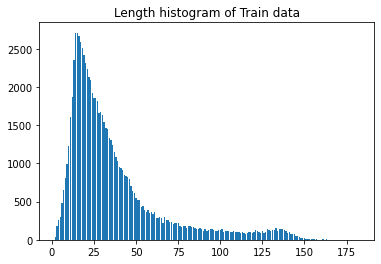

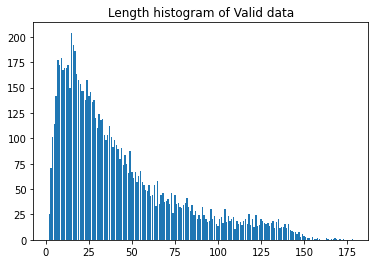

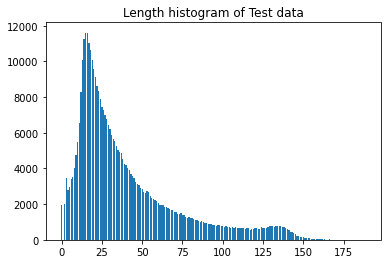

In [ ]:
length_hist(train_df, title='Length histogram of Train data')
length_hist(valid_df, title='Length histogram of Valid data')
length_hist(test_df, title='Length histogram of Test data')

In [ ]:
def cal_langth(df):
    min_length = 1e9
    max_length = 0
    for data in df['data']:
        length = len(data)
        if max_length < length:
            max_length = length
        if min_length > length:
            min_length = length
    return max_length, min_length

In [ ]:
print(f'Max / Min length of All data : {cal_langth(train_df)}')
print(f'Max / Min length of All data : {cal_langth(valid_df)}')
print(f'Max / Min length of Test data : {cal_langth(test_df)}')

Max / Min length of All data : (182, 2)
Max / Min length of All data : (178, 2)
Max / Min length of Test data : (188, 0)


In [ ]:
'''
길이가 0인 context은 후에 가장 높은 확률을 보이는 10점을 예측하도록 하고 학습에서 제외시킴

'''

def zero_data_search(df):
    zero_id_list = []
    zero_label_list = []
    for i, data in enumerate(df['data']):
        if len(data) == 0:
            zero_id_list.append(i)
            zero_label_list.append(df['label'][i])
    return zero_id_list, zero_label_list

In [ ]:
train_zero_id_list, train_zero_label_list = zero_data_search(train_df)
valid_zero_id_list, valid_zero_label_list = zero_data_search(valid_df)

In [ ]:
train_df = train_df.drop(index=train_zero_id_list, axis=0)
valid_df = valid_df.drop(index=valid_zero_id_list, axis=0)

In [ ]:
test_zero_id_list = []
for i, data in enumerate(test_df['data']):
    if len(data) == 0:
        test_zero_id_list.append(i)
print(f'Number of zero length data in test : {len(test_zero_id_list)}')

Number of zero length data in test : 1957


In [ ]:
print(f'Number of Train data : {len(train_df)}')
print(f'Number of Valid data : {len(valid_df)}')
print(f'Number of Test data : {len(test_df)}')

Number of Train data : 84699
Number of Valid data : 8798
Number of Test data : 400000


In [ ]:
def class_hist(label_counter, title=None):
    x = sorted(label_counter.keys(), key=lambda x:int(x))
    
    total_num = sum(label_counter.values())
    y = [label_counter[i]/total_num for i in x]
    
    plt.bar(x, y)
    if title is not None:
        plt.title(title)
    plt.show()

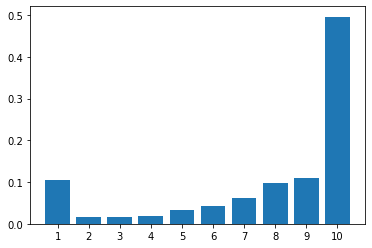

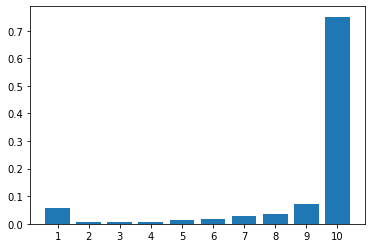

In [ ]:
'''
Class Imbalance problem

전략
1. class 별로 같은 수의 data 사용
2. Imbalanced Sampler 사용

'''

label_counter = Counter(train_df['label'])
class_hist(label_counter)

label_counter = Counter(valid_df['label'])
class_hist(label_counter)

# Training & Inference

  ## Model
    - huggingface의 pre-trianed classification model을 사용하였습니다.
    - xlm-roberta-large, koelectra-base-v3-discriminator로 실험하였습니다.

    => model의 size 크기가 더 크기 때문인지 xlm-roberta-large 모델이 더 높은 score를 보였습니다.
  ## Loss
    - Cross entropy loss
    - Focal loss
      > 데이터 수가 적은 class의 학습이 비교적 잘 되지 않는 것 같아, focal loss를 사용하여 이를 해결하려고 시도하였습니다. 
    - F1 loss
      > LB의 measure 방법인 f1 score를 loss로 사용하면 더 높은 score를 얻을 수 있다고 판단하였습니다.

    => 최종적으로 cross entropy loss와 f1 loss를 결합한 형태를 학습에 사용하였습니다.
  ## Imbalanced Sampler
    - class imbalance problem을 해결하기 위해 시도하였습니다.

    => 하지만 결과적으로 class의 imbalance 분포가 존재하는 것이 CV와 LB 모두에서 더 높은 score를 보여 최종 결과에선 사용하지 않았습니다.
<img src="https://user-images.githubusercontent.com/2270240/40677251-b08f504a-63af-11e8-9653-f28e973a5664.png"/>

  ## Scheduler
    - get_cosine_with_hard_restarts_schedule_with_warmup
      > huggingface에서 제공하는 get_cosine_with_hard_restarts_schedule_with_warmup를 사용하였습니다.
      > 경험적으로 다른 scheduler보다 gradient exploding 현상이 적어 사용하였습니다.
<img src="https://huggingface.co/transformers/_images/warmup_cosine_hard_restarts_schedule.png"/>

  ## Early Stopping
    - 고정된 epoch 수가 아닌 500 step 마다 validation dataset의 f1 score를 측정하여 overfitting 되는 시점에 학습을 종료하였습니다.

  ## Weighted probability of class 10
    - 실험을 반복한 결과 10번 class로 예측하는 경우가 더 많을수록 높은 score를 보였습니다.
    - 따라서 validation dataset과 test dataset의 softmax output에서 10번 class의 확률에만 weight를 추가해주었습니다.
  ## k fold cross validation
    - 단일 모델로 실험을 반복하여 성능을 높인 후 최종 submission은 10개의 fold를 사용하여 각각의 모델 별로 output을 soft voting 하여 구했습니다.


In [ ]:
import os
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader

from scipy.special import softmax
from sklearn.metrics import f1_score
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import AdamW, get_cosine_with_hard_restarts_schedule_with_warmup

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
# hyper parameter setting
class CFG:
    mode = 'kfold' # train or inference or kfold

    seed = 2021
    num_workers = 4
    
    epoch = 10
    batch_size = 32

    model = 'xlm-roberta-large'
    # model = 'monologg/koelectra-base-v3-discriminator'

    learning_rate = 5e-6
    weight_decay = 0.0001
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, ds):
        self.label_list = ds.label_list
        self.indices = list(range(len(ds)))
        self.num_samples = len(self.indices)

        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(idx)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, idx):
        return self.label_list[idx]
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [ ]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, threshold=0):
        self.df = df
        self.threshold = threshold
        
        self.label_list = self.df['label']

        text_list = self.df['data']
        tokenized_text = tokenizer(text_list.tolist(),
                                   return_tensors="pt",
                                   padding='max_length',
                                   max_length=50,
                                   truncation=True,
                                   add_special_tokens=True)
        self.input_ids = tokenized_text['input_ids']
        self.attention_mask = tokenized_text['attention_mask']
        if not 'xlm-roberta' in CFG.model:
            self.token_type_ids = tokenized_text['token_type_ids']

    def __getitem__(self, idx):
        if 'xlm-roberta' in CFG.model:
            if self.threshold > 0:
                return self._random_enk(self.input_ids[idx]), self.attention_mask[idx], torch.tensor(int(self.label_list[idx])-1)
            else:
                return self.input_ids[idx], self.attention_mask[idx], torch.tensor(int(self.label_list[idx])-1)
        else:
            return self.input_ids[idx], self.attention_mask[idx], self.token_type_ids[idx], torch.tensor(int(self.label_list[idx])-1)
          
    def __len__(self):
        return len(self.df)

    def _random_enk(self, input_ids):

        special_token_list = [0, 1, 2, 3]
        
        for i, token in enumerate(input_ids):
            if token in special_token_list: continue
            elif self.threshold > random.random():
                input_ids[i] = 250001
        return input_ids

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, test_df, tokenizer):
        self.test_df = test_df

        self.id_list = self.test_df['id']

        text_list = self.test_df['data']
        tokenized_text = tokenizer(text_list.tolist(),
                                   return_tensors="pt",
                                   padding='max_length',
                                   max_length=50,
                                   truncation=True,
                                   add_special_tokens=True)
        
        self.input_ids = tokenized_text['input_ids']
        self.attention_mask = tokenized_text['attention_mask']
        if not 'xlm-roberta' in CFG.model:
            self.token_type_ids = tokenized_text['token_type_ids']
        
    def __getitem__(self, idx):
        if 'xlm-roberta' in CFG.model:
            return self.input_ids[idx], self.attention_mask[idx], self.id_list[idx]
        else:
            return self.input_ids[idx], self.attention_mask[idx], self.token_type_ids[idx], self.id_list[idx]
        
    def __len__(self):
        return len(self.test_df)

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, classes=10, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon
    
    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        
        ce_loss =  nn.functional.cross_entropy(y_pred, y_true)
        # focal_loss =  self._focal_loss(y_pred, y_true)
        f1_loss = self._f1_loss(y_pred, y_true)

        # return f1_loss
        return f1_loss + ce_loss
        # return f1_loss + focal_loss

    def _f1_loss(self, y_pred, y_true):
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        
        f1_loss = 1 - f1.mean()
        return f1_loss
    
    def _focal_loss(self, y_pred, y_true):
        log_prob = F.log_softmax(y_pred, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(((1 - prob) ** 2) * log_prob, y_true, weight=None, reduction='mean')

In [ ]:
# validation measuring
def valid_one_epoch(epoch, model, loss_fn, val_loader, device):
    model.to(CFG.device).eval()

    loss_sum = 0
    sample_num = 0
    
    preds_all = []
    targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader), position=0, leave=True)
    for step, batch in pbar:
        label = batch[-1]
        
        batch = tuple(t.to(device) for t in batch[:-1])

        if 'xlm-roberta' in CFG.model:
            outputs = model(input_ids=batch[0],
                            attention_mask=batch[1])[0]
        else:
            outputs = model(input_ids=batch[0],
                            attention_mask=batch[1],
                            token_type_ids=batch[2],
                            return_dict=False)[0]
                            
        outputs = F.softmax(outputs, dim=1)
        outputs[:,-1] += 0.1

        preds_all += [torch.argmax(outputs, 1).detach().cpu().numpy()]
        targets_all += [label.detach().cpu().numpy()]
        
        loss = loss_fn(outputs, label.to(device))
        
        loss_sum += loss.item()*label.shape[0]
        sample_num += label.shape[0]
        
        if ((step + 1) % 1 == 0) or ((step + 1) == len(val_loader)):
            preds = np.concatenate(preds_all)
            targets = np.concatenate(targets_all)
            
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    preds_all = np.concatenate(preds_all)

    label_counter = Counter(preds_all.tolist())
    class_hist(label_counter)

    targets_all = np.concatenate(targets_all)
    accuracy = (preds_all==targets_all).mean()
    f1 = f1_score(preds_all, targets_all, average='macro')
    print('validation accuracy = {:.4f}, f1 score = {:.4f}'.format(accuracy, f1))
    return accuracy, f1

In [ ]:
config = AutoConfig.from_pretrained(CFG.model)
config.num_labels = 10
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
model = AutoModelForSequenceClassification.from_pretrained(CFG.model, config=config).to(CFG.device)

if CFG.mode == 'inference':
    model.load_state_dict(torch.load(f'{cfg.save_path}/best_model.pt'))

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.den

In [ ]:
if CFG.mode == 'train':
    train_ds = NLPDataset(train_df, tokenizer, threshold=0)
    valid_ds = NLPDataset(valid_df, tokenizer)

In [ ]:
if CFG.mode == 'train':
    imbalanced_sampler = ImbalancedDatasetSampler(train_ds)

    train_loader = DataLoader(
        train_ds,
        batch_size=CFG.batch_size,
        pin_memory=True,
        drop_last=False,
        shuffle=True,
        # sampler=imbalanced_sampler,
        num_workers=CFG.num_workers,
    )

    val_loader = DataLoader(
        valid_ds,
        batch_size=CFG.batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=CFG.num_workers,
    )

In [ ]:
if CFG.mode in ['train', 'kfold']:
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [{'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': CFG.weight_decay},
                                    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

    scaler = GradScaler()
    loss_fn = CustomLoss()
    optimizer = AdamW(optimizer_grouped_parameters, lr=CFG.learning_rate, eps=1e-8)
    scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer=optimizer,
                                                                  num_warmup_steps=len(train_df)//CFG.batch_size,
                                                                  num_training_steps=len(train_df),
                                                                  num_cycles=2)

In [ ]:
if CFG.mode == 'train':
    seed_everything(CFG.seed)

    best_accuracy = 0
    best_f1 = 0
    best_epoch = 0
    stop_count = 0
    global_step = 0

    for epoch in range(CFG.epoch):
        # training
        model.train()

        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for step, batch in pbar:
            global_step += 1
            label = batch[-1]
            with autocast():
                model.to(CFG.device).train()
                batch = tuple(t.to(CFG.device) for t in batch[:-1])

                if 'xlm-roberta' in CFG.model:
                    outputs = model(input_ids=batch[0],
                                    attention_mask=batch[1])[0]
                else:
                    outputs = model(input_ids=batch[0],
                                    attention_mask=batch[1],
                                    token_type_ids=batch[2],
                                    return_dict=False)[0]
                
                preds = torch.argmax(outputs, 1).detach().cpu().numpy()
                
                loss = loss_fn(outputs, label.to(CFG.device))
                scaler.scale(loss).backward()
                
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

                if scheduler is not None:
                    scheduler.step()

                accuracy = (preds==label.detach().cpu().numpy()).mean()
                f1 = f1_score(preds, label.detach().cpu().numpy(), average='macro')
                
                description = f'global_step-{global_step} loss: {loss.item():.4f} acc: {accuracy:.4f} f1: {f1:.4f}'
                pbar.set_description(description)
                
            if (global_step + 1) % 500 == 0:
                with torch.no_grad():
                    epoch_accuracy, epoch_f1 = valid_one_epoch(epoch, model, loss_fn, val_loader, CFG.device)
                
                if epoch_f1 > best_f1:
                    stop_count = 0
                    best_state_dict = copy.deepcopy(model.cpu().state_dict())
                    
                    best_accuracy = epoch_accuracy
                    best_f1 = epoch_f1
                    best_epoch = epoch

                    print('\t!! Best Model Save !!')
                else:
                    # early stopping
                    stop_count += 1
            if stop_count > 3:
                break
        if stop_count > 3:
            break

    print('Best Accuracy: {} / Best F1 score: {} in epoch {}'.format(best_accuracy, best_f1, best_epoch))

    # 저장되어 있는 best model을 load 해옵니다.
    model.cpu().load_state_dict(best_state_dict)
    torch.save(model.state_dict(), f'{cfg.save_path}/best_model.pt')
    print('The model is saved!')

In [ ]:
if CFG.mode == 'inference':
    valid_ds = NLPDataset(valid_df, tokenizer)
    test_dataset = TestDataset(test_df, tokenizer)

    val_loader = DataLoader(
        valid_ds,
        batch_size=CFG.batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=CFG.num_workers,
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=CFG.batch_size,
        shuffle=False
    )

In [ ]:
if CFG.mode == 'inference':
    loss_fn = CustomLoss()
    
    test_pred_id = []
    all_predictions = []
    with torch.no_grad():
        best_accuracy, best_f1 = valid_one_epoch(-1, model, loss_fn, val_loader, CFG.device)
        print('Best Accuracy: {} / Best F1 score: {}'.format(best_accuracy, best_f1))

        for batch in tqdm(test_loader):
            batch = tuple(t.to(CFG.device) for t in batch[:-1])
            
            if 'xlm-roberta' in CFG.model:
                pred = model(input_ids=batch[0],
                              attention_mask=batch[1])[0]
            else:
                pred = model(input_ids=batch[0],
                              attention_mask=batch[1],
                              token_type_ids=batch[2],
                              return_dict=False)[0]
            all_predictions.extend(pred.cpu().numpy())
        all_predictions = np.array(all_predictions)

In [ ]:
if CFG.mode == 'inference':
    all_result = softmax(all_predictions, axis=1)

    all_weight_result = copy.deepcopy(all_result)
    all_weight_result[:,-1] += 0.1

    all_result = np.argmax(all_result, axis=1)
    all_weight_result = np.argmax(all_weight_result, axis=1)

    all_result[test_zero_id_list] = 9
    all_result += 1

    all_weight_result[test_zero_id_list] = 9
    all_weight_result += 1

    label_counter = Counter(all_result.tolist())
    class_hist(label_counter)

    label_counter = Counter(all_weight_result.tolist())
    class_hist(label_counter)

    submission = pd.read_csv(cfg.submission_path)
    submission['Prediction'] = all_result
    # submission.to_csv(f'{cfg.save_result_path}/all_result_35.csv', index = None)

    submission = pd.read_csv(cfg.submission_path)
    submission['Prediction'] = all_weight_result
    # submission.to_csv(f'{cfg.save_result_path}/all_weight_result_34.csv', index = None)

Training with 0 started


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


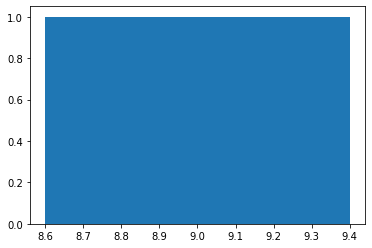

validation accuracy = 0.5200, f1 score = 0.0684
	!! Best Model Save !!


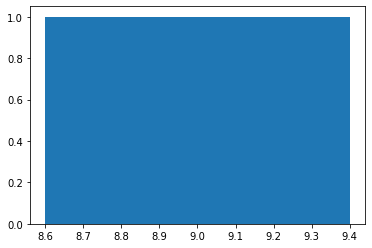

validation accuracy = 0.5200, f1 score = 0.0684


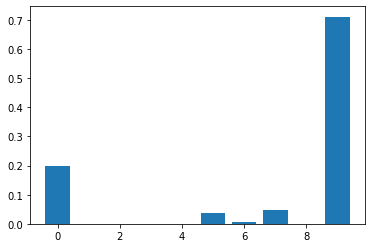

validation accuracy = 0.5754, f1 score = 0.1676
	!! Best Model Save !!


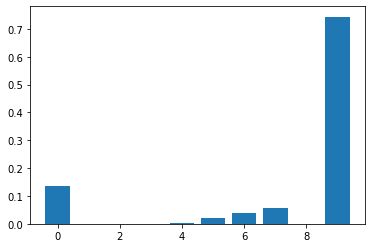

validation accuracy = 0.5954, f1 score = 0.1968
	!! Best Model Save !!


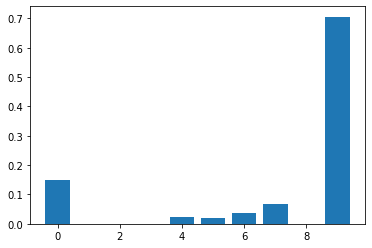

validation accuracy = 0.5953, f1 score = 0.2116
	!! Best Model Save !!



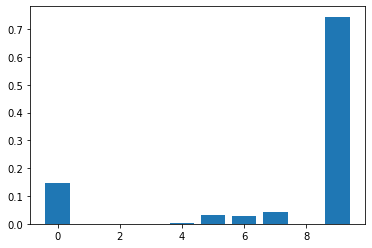

validation accuracy = 0.6018, f1 score = 0.1982


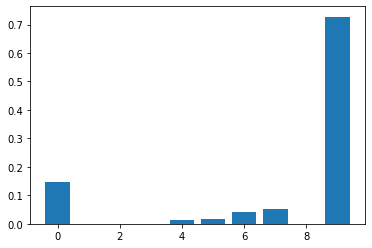

validation accuracy = 0.6043, f1 score = 0.2102


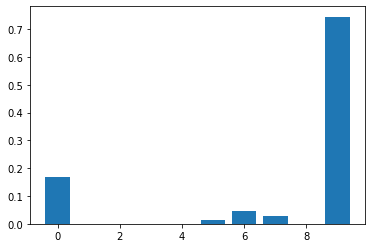

validation accuracy = 0.6055, f1 score = 0.1846


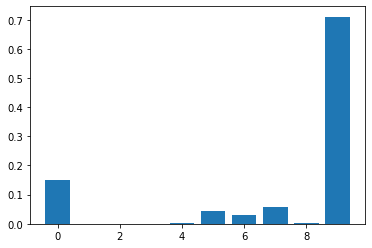

validation accuracy = 0.6103, f1 score = 0.2139
	!! Best Model Save !!


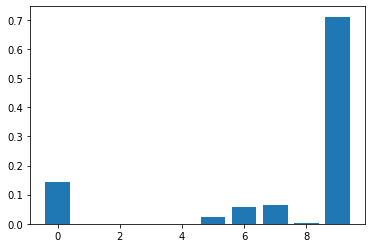

validation accuracy = 0.6091, f1 score = 0.2107



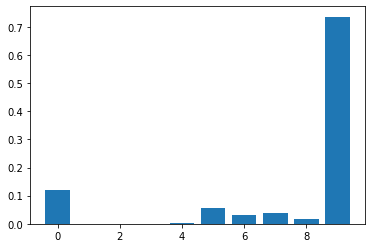

validation accuracy = 0.6114, f1 score = 0.2158
	!! Best Model Save !!


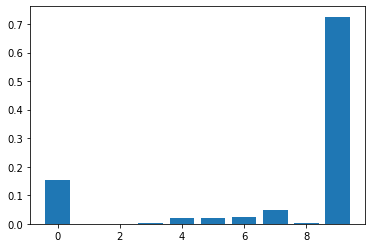

validation accuracy = 0.6124, f1 score = 0.2147


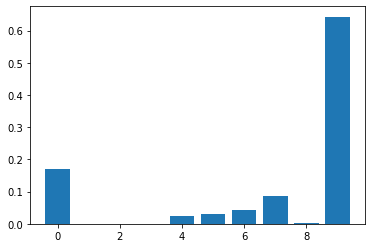

validation accuracy = 0.6036, f1 score = 0.2274
	!! Best Model Save !!


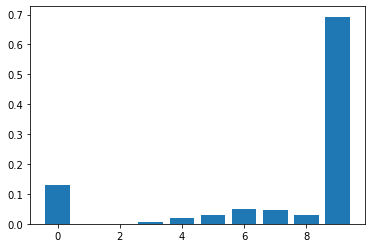

validation accuracy = 0.6149, f1 score = 0.2432
	!! Best Model Save !!


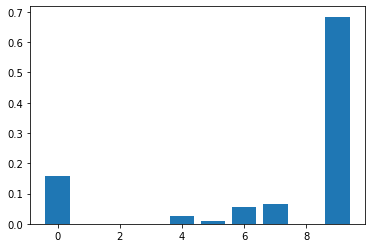

validation accuracy = 0.6169, f1 score = 0.2252



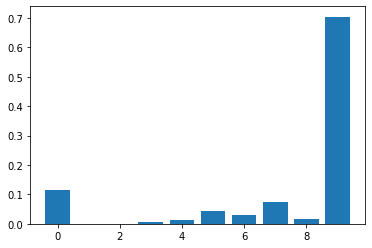

validation accuracy = 0.6181, f1 score = 0.2403


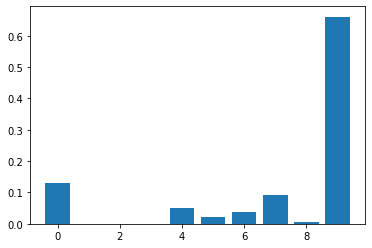

validation accuracy = 0.6132, f1 score = 0.2439
	!! Best Model Save !!


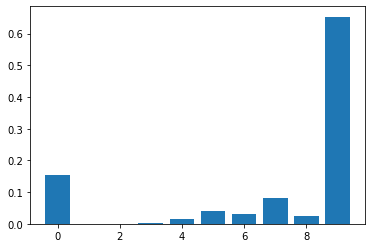

validation accuracy = 0.6130, f1 score = 0.2412


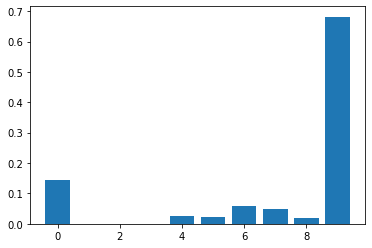

validation accuracy = 0.6214, f1 score = 0.2456
	!! Best Model Save !!


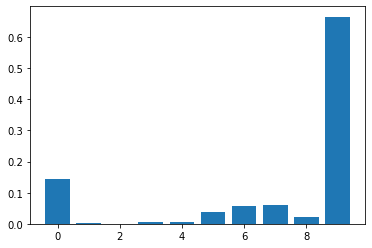

validation accuracy = 0.6141, f1 score = 0.2463
	!! Best Model Save !!


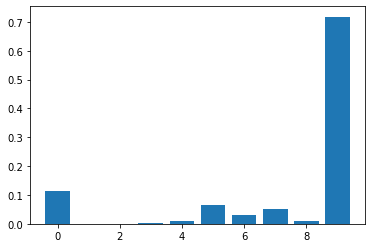

validation accuracy = 0.6186, f1 score = 0.2369



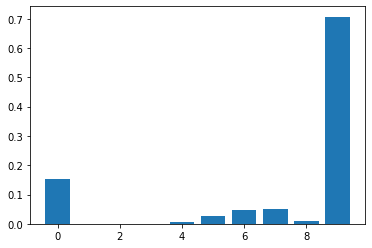

validation accuracy = 0.6212, f1 score = 0.2265


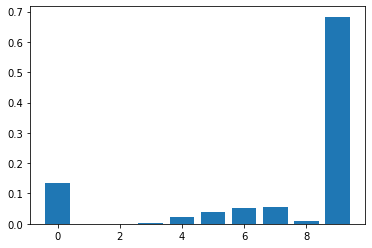

validation accuracy = 0.6210, f1 score = 0.2511
	!! Best Model Save !!


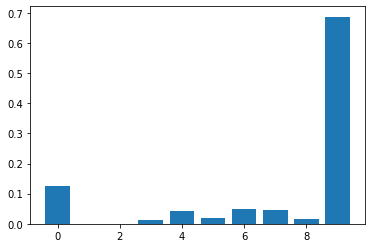

validation accuracy = 0.6170, f1 score = 0.2494


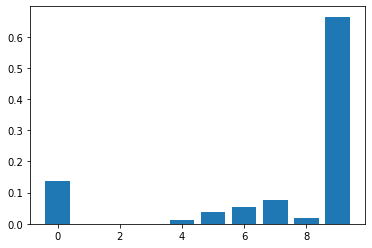

validation accuracy = 0.6207, f1 score = 0.2484


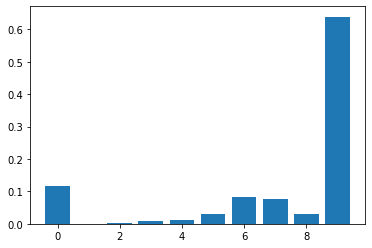

validation accuracy = 0.6095, f1 score = 0.2604
	!! Best Model Save !!



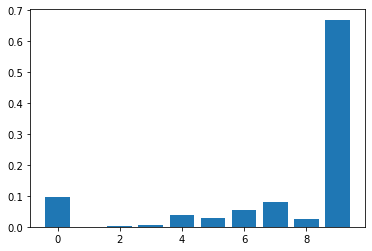

validation accuracy = 0.6104, f1 score = 0.2595


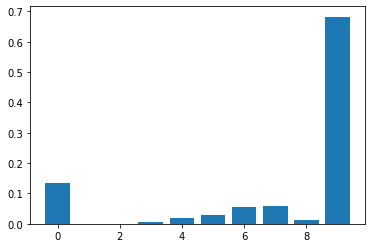

validation accuracy = 0.6184, f1 score = 0.2460


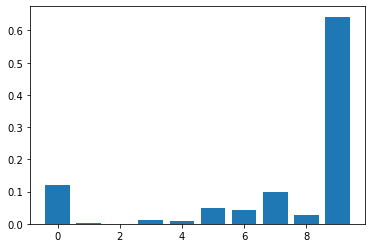

validation accuracy = 0.6155, f1 score = 0.2686
	!! Best Model Save !!


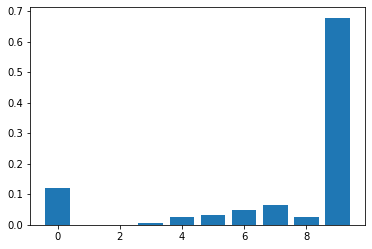

validation accuracy = 0.6198, f1 score = 0.2601


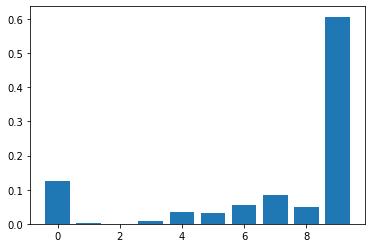

validation accuracy = 0.6081, f1 score = 0.2778
	!! Best Model Save !!



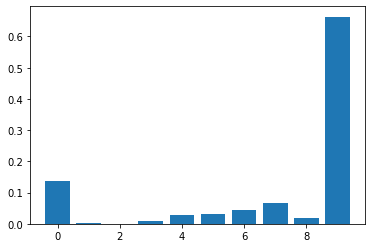

validation accuracy = 0.6226, f1 score = 0.2647


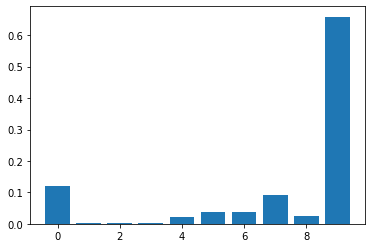

validation accuracy = 0.6158, f1 score = 0.2602


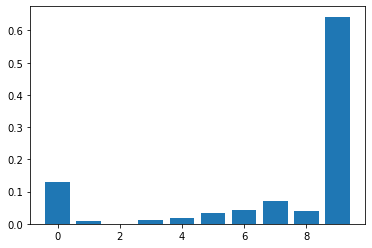

validation accuracy = 0.6136, f1 score = 0.2725


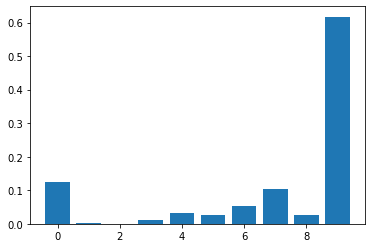

validation accuracy = 0.6095, f1 score = 0.2735
Best Accuracy: 0.6081283422459893 / Best F1 score: 0.2777970426125817 in epoch 5
Best model load!



Training with 1 started


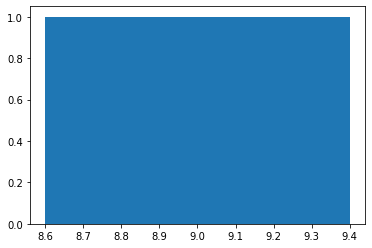

validation accuracy = 0.5200, f1 score = 0.0684
	!! Best Model Save !!


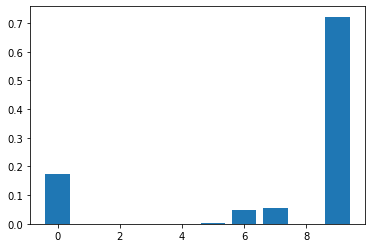

validation accuracy = 0.5785, f1 score = 0.1755
	!! Best Model Save !!


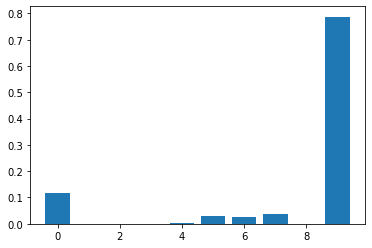

validation accuracy = 0.5913, f1 score = 0.1881
	!! Best Model Save !!


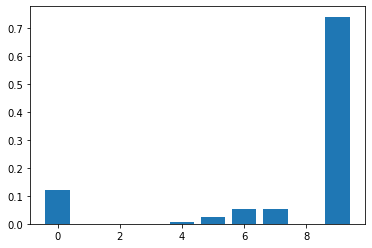

validation accuracy = 0.5996, f1 score = 0.2086
	!! Best Model Save !!


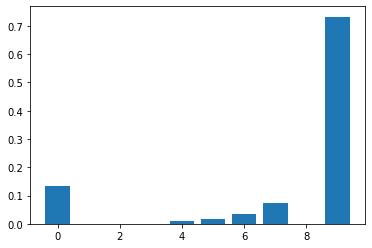

validation accuracy = 0.6012, f1 score = 0.2067



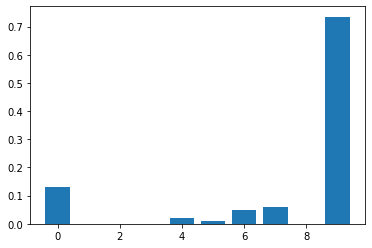

validation accuracy = 0.6062, f1 score = 0.2107
	!! Best Model Save !!


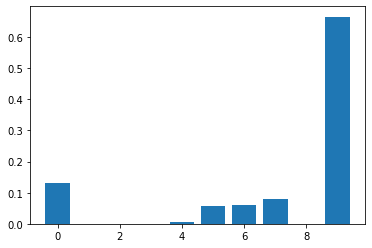

validation accuracy = 0.5948, f1 score = 0.2153
	!! Best Model Save !!


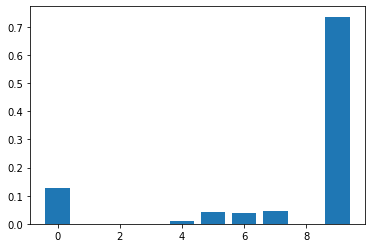

validation accuracy = 0.6089, f1 score = 0.2161
	!! Best Model Save !!


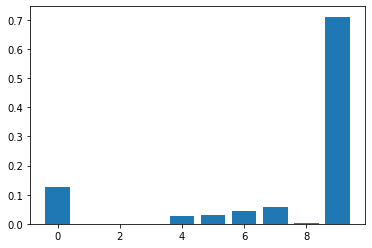

validation accuracy = 0.6079, f1 score = 0.2225
	!! Best Model Save !!


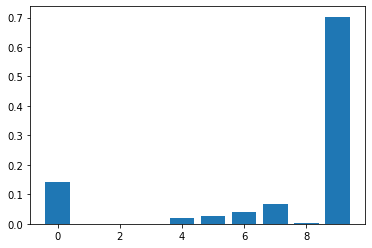

validation accuracy = 0.6079, f1 score = 0.2202



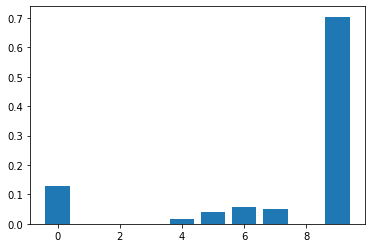

validation accuracy = 0.6095, f1 score = 0.2260
	!! Best Model Save !!


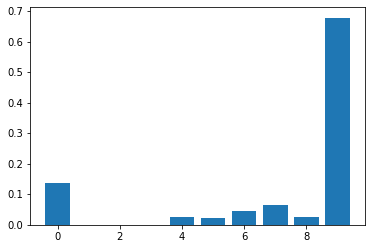

validation accuracy = 0.6088, f1 score = 0.2347
	!! Best Model Save !!


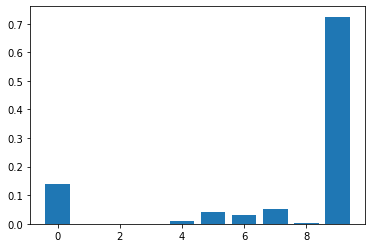

validation accuracy = 0.6126, f1 score = 0.2152


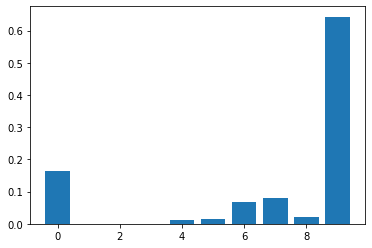

validation accuracy = 0.6055, f1 score = 0.2265


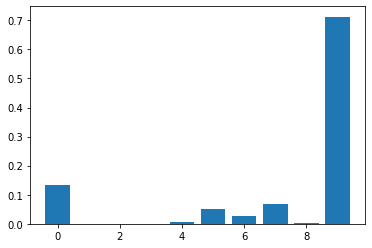

validation accuracy = 0.6145, f1 score = 0.2195



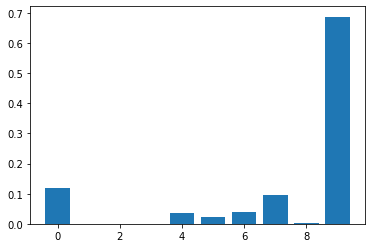

validation accuracy = 0.6091, f1 score = 0.2289
Best Accuracy: 0.6087700534759358 / Best F1 score: 0.23468749031726394 in epoch 2
Best model load!



Training with 2 started


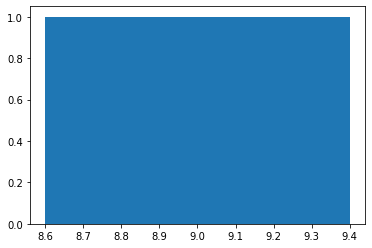

validation accuracy = 0.5200, f1 score = 0.0684
	!! Best Model Save !!


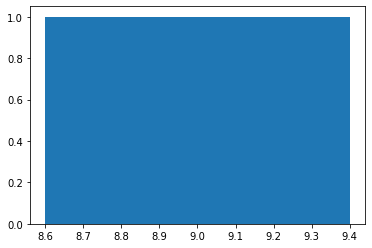

validation accuracy = 0.5200, f1 score = 0.0684


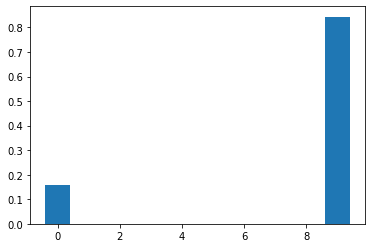

validation accuracy = 0.5630, f1 score = 0.1174
	!! Best Model Save !!


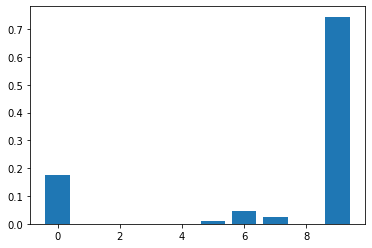

validation accuracy = 0.5861, f1 score = 0.1746
	!! Best Model Save !!


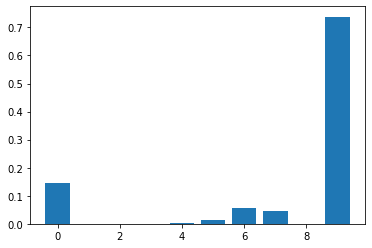

validation accuracy = 0.5981, f1 score = 0.1923
	!! Best Model Save !!



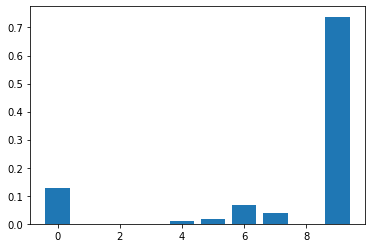

validation accuracy = 0.6009, f1 score = 0.2067
	!! Best Model Save !!


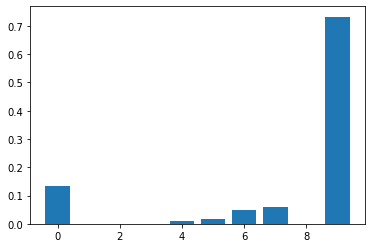

validation accuracy = 0.6059, f1 score = 0.2077
	!! Best Model Save !!


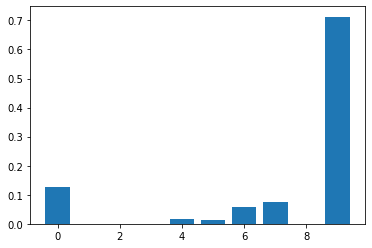

validation accuracy = 0.6067, f1 score = 0.2173
	!! Best Model Save !!


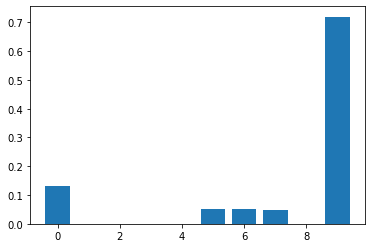

validation accuracy = 0.6065, f1 score = 0.2080


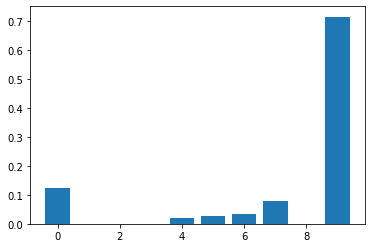

validation accuracy = 0.6090, f1 score = 0.2221
	!! Best Model Save !!



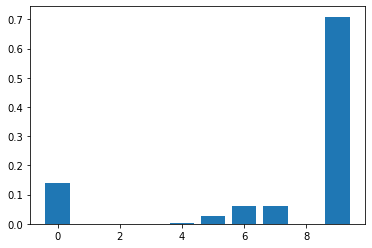

validation accuracy = 0.6103, f1 score = 0.2111


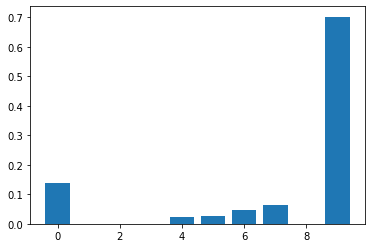

validation accuracy = 0.6098, f1 score = 0.2233
	!! Best Model Save !!


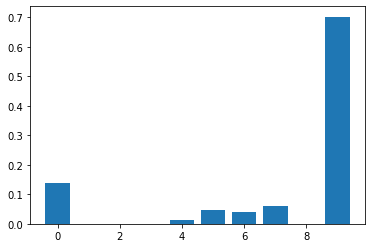

validation accuracy = 0.6136, f1 score = 0.2263
	!! Best Model Save !!


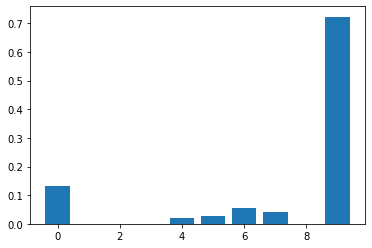

validation accuracy = 0.6120, f1 score = 0.2198


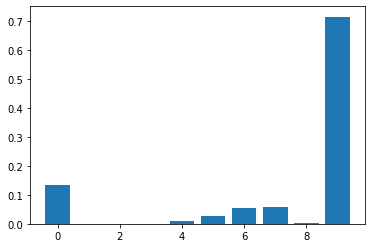

validation accuracy = 0.6130, f1 score = 0.2200



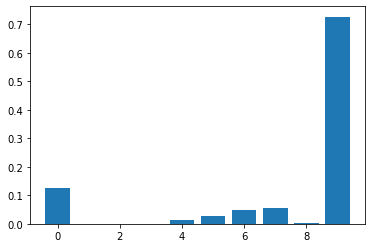

validation accuracy = 0.6132, f1 score = 0.2220


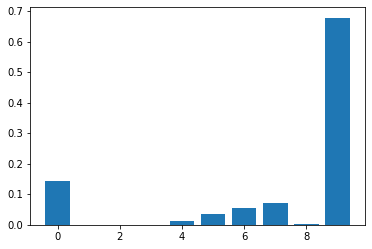

validation accuracy = 0.6122, f1 score = 0.2287
	!! Best Model Save !!


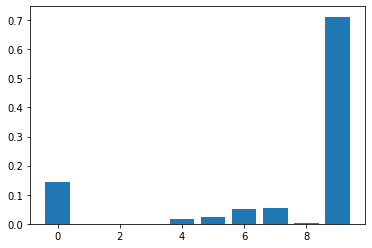

validation accuracy = 0.6147, f1 score = 0.2187


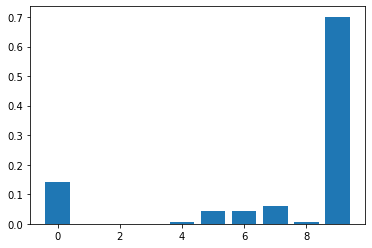

validation accuracy = 0.6164, f1 score = 0.2283


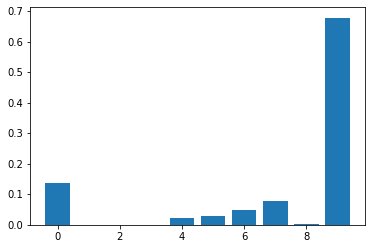

validation accuracy = 0.6141, f1 score = 0.2371
	!! Best Model Save !!


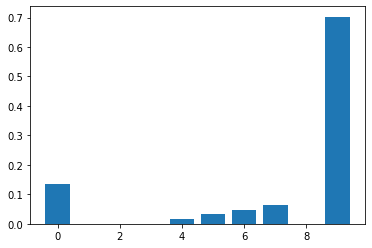

validation accuracy = 0.6169, f1 score = 0.2313



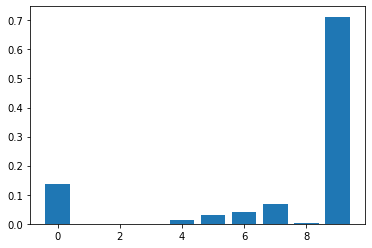

validation accuracy = 0.6180, f1 score = 0.2282


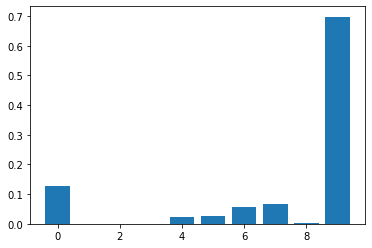

validation accuracy = 0.6164, f1 score = 0.2356


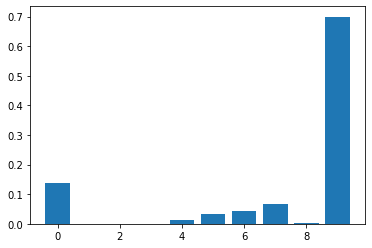

validation accuracy = 0.6168, f1 score = 0.2305
Best Accuracy: 0.6141176470588235 / Best F1 score: 0.2370965571459608 in epoch 3
Best model load!



Training with 3 started


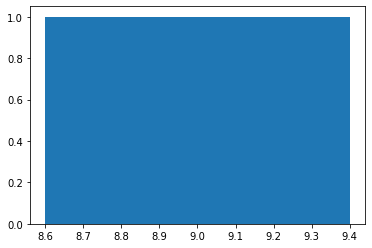

validation accuracy = 0.5200, f1 score = 0.0684
	!! Best Model Save !!


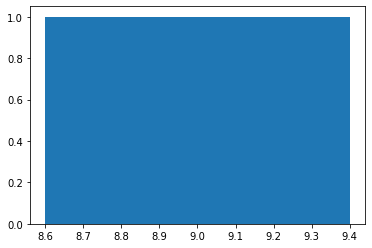

validation accuracy = 0.5200, f1 score = 0.0684


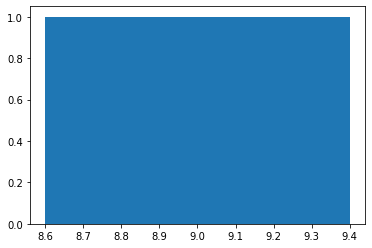

validation accuracy = 0.5200, f1 score = 0.0684


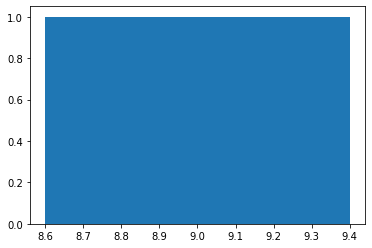

validation accuracy = 0.5200, f1 score = 0.0684


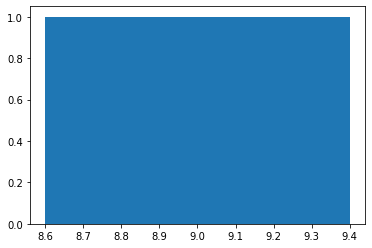

validation accuracy = 0.5200, f1 score = 0.0684
Best Accuracy: 0.52 / Best F1 score: 0.06842105263157895 in epoch 0
Best model load!



Training with 4 started


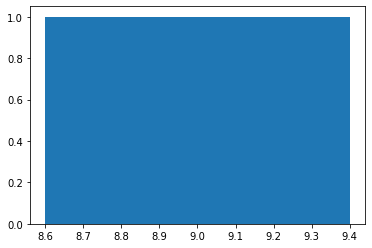

validation accuracy = 0.5200, f1 score = 0.0684
	!! Best Model Save !!


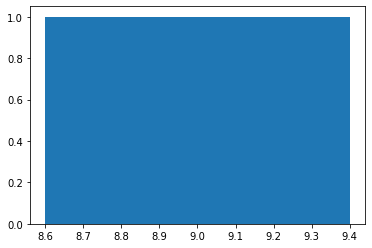

validation accuracy = 0.5200, f1 score = 0.0684


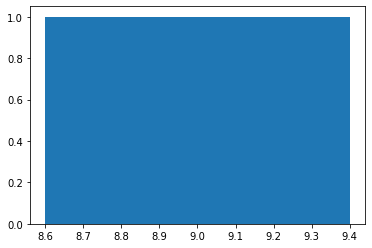

validation accuracy = 0.5200, f1 score = 0.0684


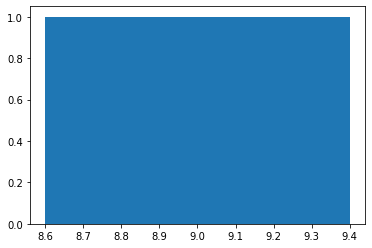

validation accuracy = 0.5200, f1 score = 0.0684


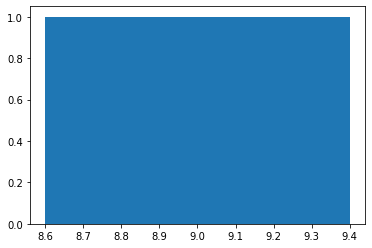

validation accuracy = 0.5200, f1 score = 0.0684
Best Accuracy: 0.52 / Best F1 score: 0.06842105263157895 in epoch 0
Best model load!



Training with 5 started


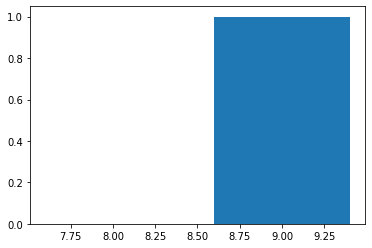

validation accuracy = 0.5197, f1 score = 0.0684
	!! Best Model Save !!


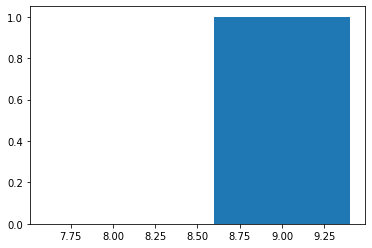

validation accuracy = 0.5199, f1 score = 0.0684
	!! Best Model Save !!


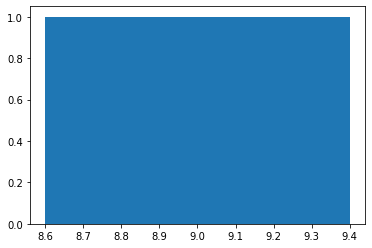

validation accuracy = 0.5200, f1 score = 0.0684
	!! Best Model Save !!


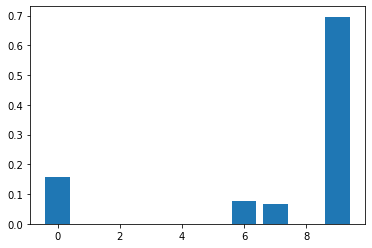

validation accuracy = 0.5928, f1 score = 0.1853
	!! Best Model Save !!


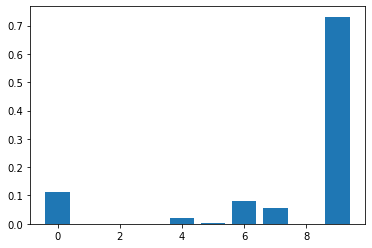

validation accuracy = 0.6006, f1 score = 0.2065
	!! Best Model Save !!



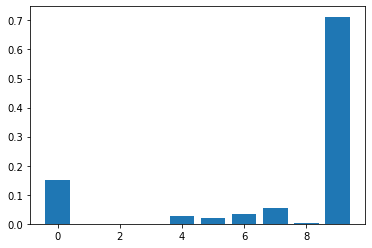

validation accuracy = 0.6047, f1 score = 0.2168
	!! Best Model Save !!


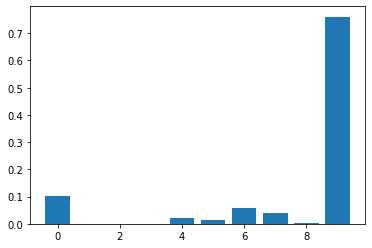

validation accuracy = 0.6032, f1 score = 0.2132


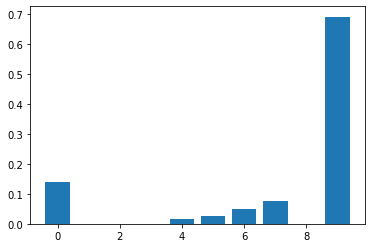

validation accuracy = 0.6101, f1 score = 0.2298
	!! Best Model Save !!


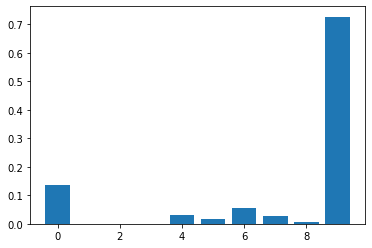

validation accuracy = 0.6136, f1 score = 0.2236


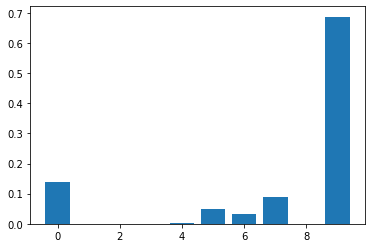

validation accuracy = 0.6136, f1 score = 0.2218



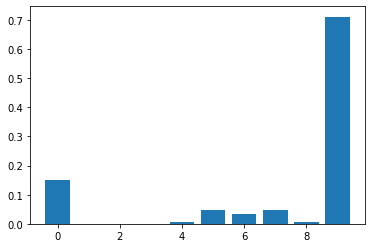

validation accuracy = 0.6160, f1 score = 0.2214


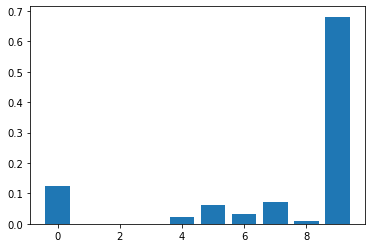

validation accuracy = 0.6135, f1 score = 0.2376
	!! Best Model Save !!


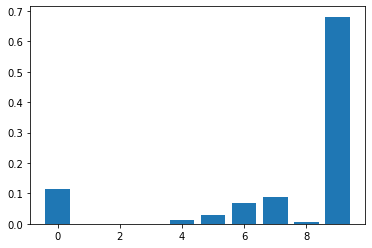

validation accuracy = 0.6139, f1 score = 0.2348


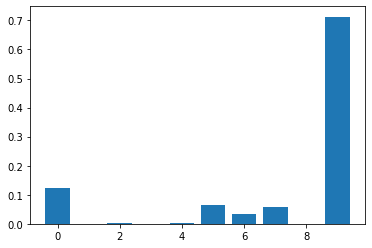

validation accuracy = 0.6160, f1 score = 0.2279


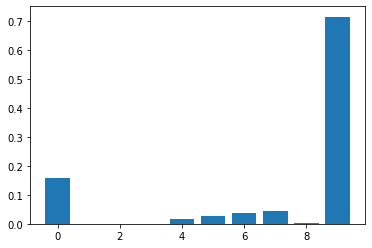

validation accuracy = 0.6178, f1 score = 0.2270



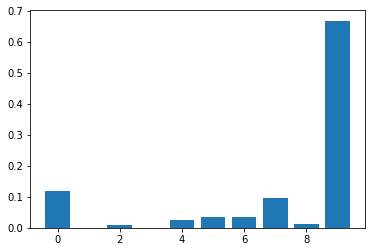

validation accuracy = 0.6094, f1 score = 0.2447
	!! Best Model Save !!


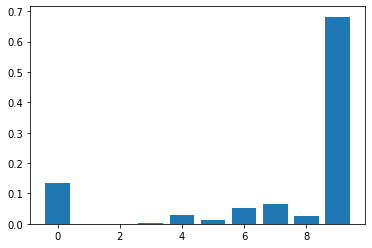

validation accuracy = 0.6152, f1 score = 0.2460
	!! Best Model Save !!


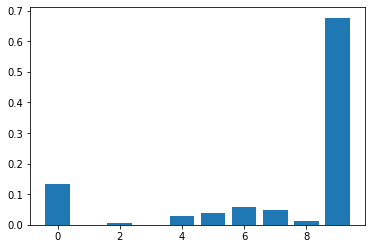

validation accuracy = 0.6147, f1 score = 0.2450


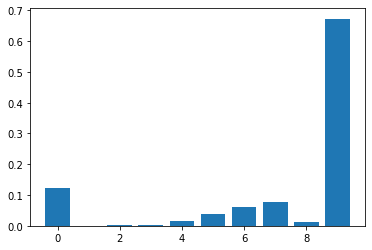

validation accuracy = 0.6154, f1 score = 0.2496
	!! Best Model Save !!


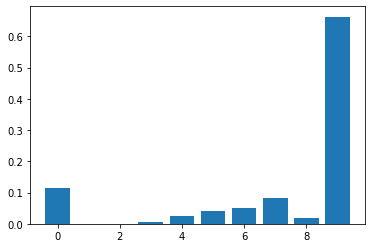

validation accuracy = 0.6114, f1 score = 0.2495


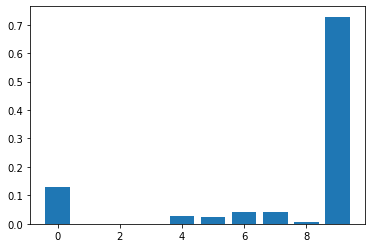

validation accuracy = 0.6194, f1 score = 0.2335



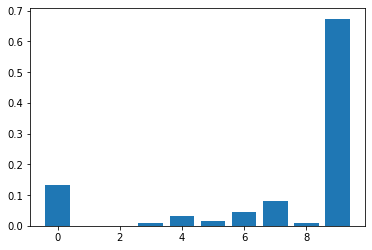

validation accuracy = 0.6179, f1 score = 0.2526
	!! Best Model Save !!


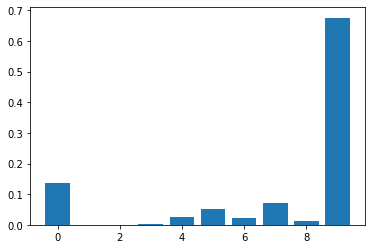

validation accuracy = 0.6127, f1 score = 0.2429


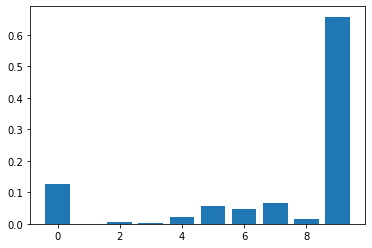

validation accuracy = 0.6132, f1 score = 0.2561
	!! Best Model Save !!


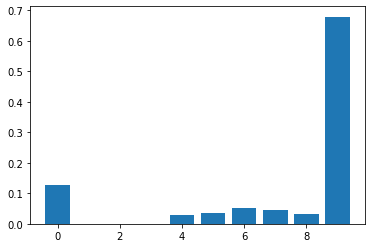

validation accuracy = 0.6134, f1 score = 0.2468


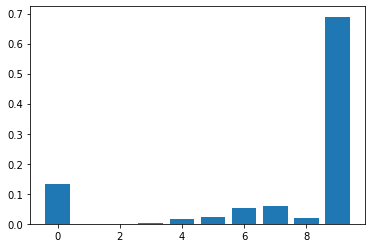

validation accuracy = 0.6191, f1 score = 0.2495



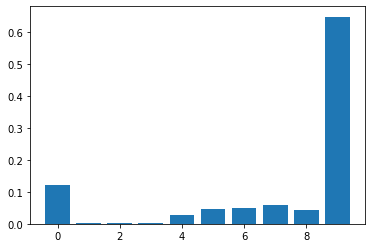

validation accuracy = 0.6111, f1 score = 0.2622
	!! Best Model Save !!


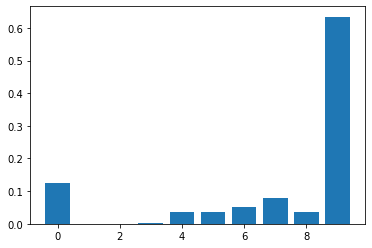

validation accuracy = 0.6081, f1 score = 0.2581


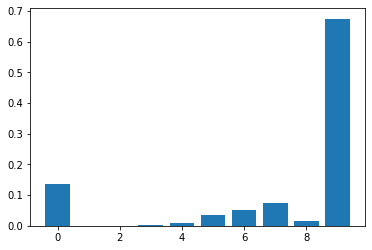

validation accuracy = 0.6179, f1 score = 0.2456


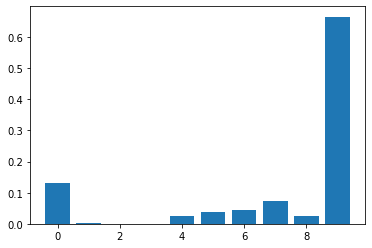

validation accuracy = 0.6174, f1 score = 0.2575


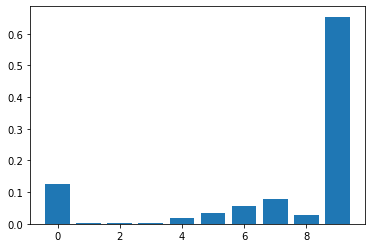

validation accuracy = 0.6153, f1 score = 0.2559
Best Accuracy: 0.6111229946524064 / Best F1 score: 0.2622084148328713 in epoch 5
Best model load!



Training with 6 started


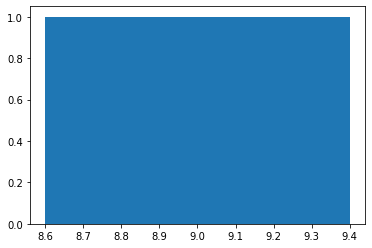

validation accuracy = 0.5200, f1 score = 0.0684
	!! Best Model Save !!


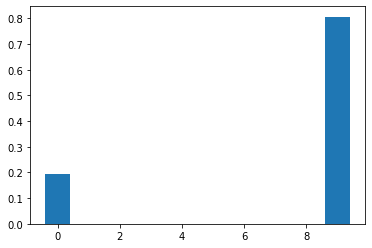

validation accuracy = 0.5696, f1 score = 0.1218
	!! Best Model Save !!


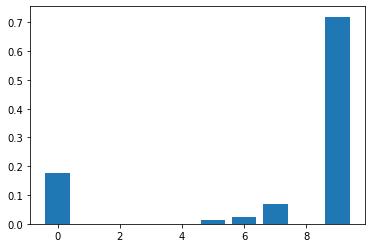

validation accuracy = 0.5926, f1 score = 0.1853
	!! Best Model Save !!


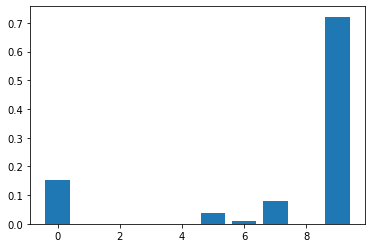

validation accuracy = 0.6003, f1 score = 0.1944
	!! Best Model Save !!


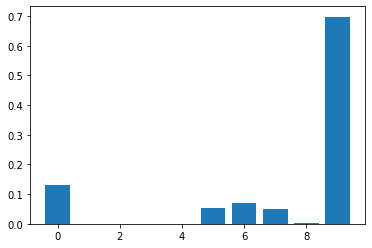

validation accuracy = 0.6012, f1 score = 0.2103
	!! Best Model Save !!



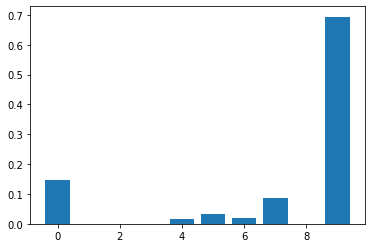

validation accuracy = 0.6052, f1 score = 0.2146
	!! Best Model Save !!


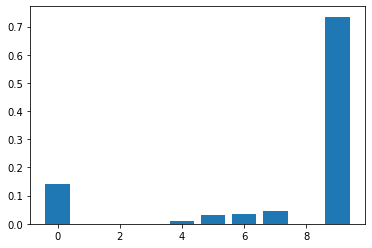

validation accuracy = 0.6104, f1 score = 0.2125


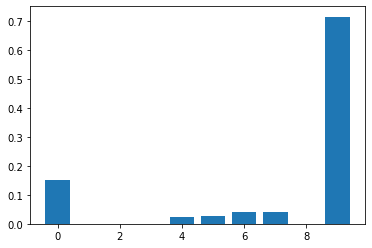

validation accuracy = 0.6089, f1 score = 0.2163
	!! Best Model Save !!


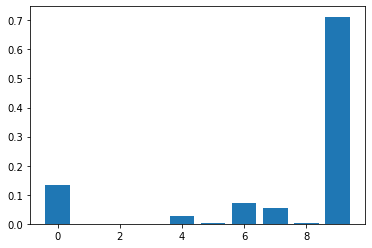

validation accuracy = 0.6132, f1 score = 0.2164
	!! Best Model Save !!


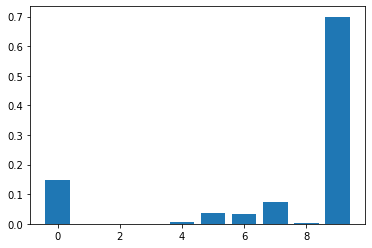

validation accuracy = 0.6138, f1 score = 0.2184
	!! Best Model Save !!



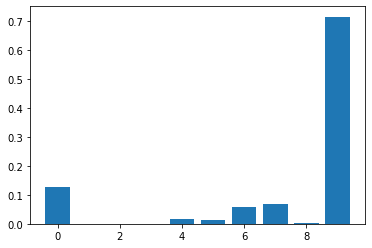

validation accuracy = 0.6132, f1 score = 0.2197
	!! Best Model Save !!


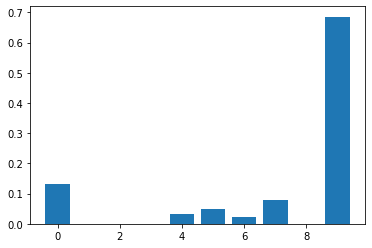

validation accuracy = 0.6108, f1 score = 0.2285
	!! Best Model Save !!


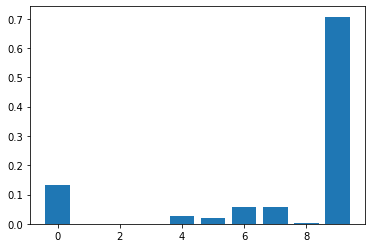

validation accuracy = 0.6157, f1 score = 0.2280


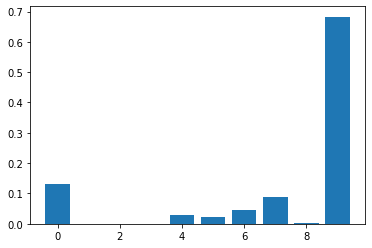

validation accuracy = 0.6158, f1 score = 0.2379
	!! Best Model Save !!


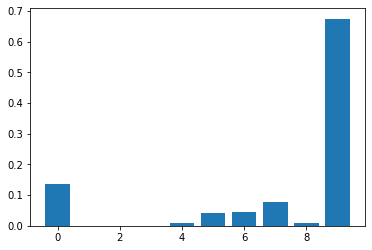

validation accuracy = 0.6132, f1 score = 0.2325



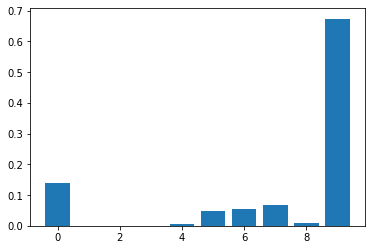

validation accuracy = 0.6129, f1 score = 0.2306


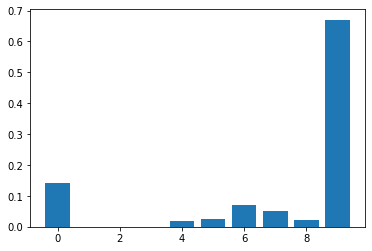

validation accuracy = 0.6133, f1 score = 0.2361


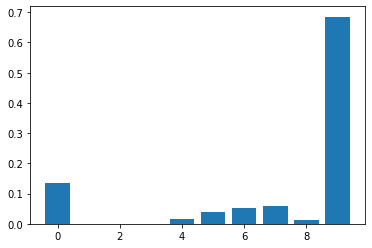

validation accuracy = 0.6170, f1 score = 0.2391
	!! Best Model Save !!


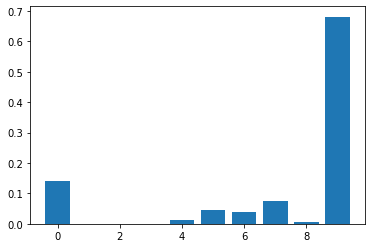

validation accuracy = 0.6154, f1 score = 0.2294


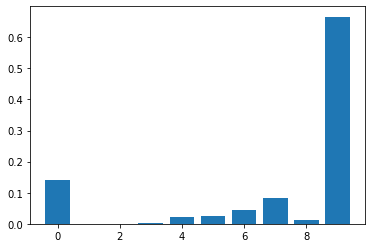

validation accuracy = 0.6152, f1 score = 0.2414
	!! Best Model Save !!


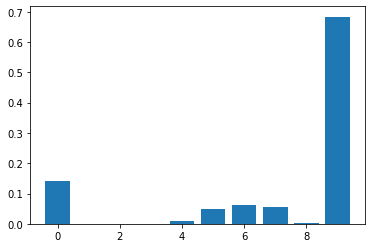

validation accuracy = 0.6164, f1 score = 0.2302



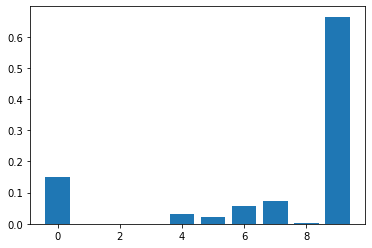

validation accuracy = 0.6134, f1 score = 0.2321


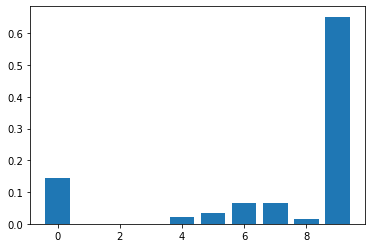

validation accuracy = 0.6151, f1 score = 0.2457
	!! Best Model Save !!


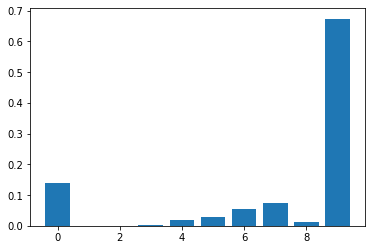

validation accuracy = 0.6165, f1 score = 0.2382


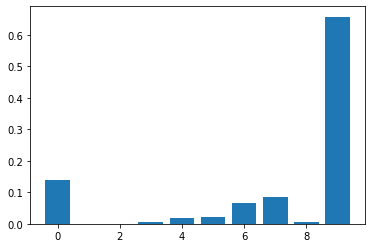

validation accuracy = 0.6134, f1 score = 0.2410


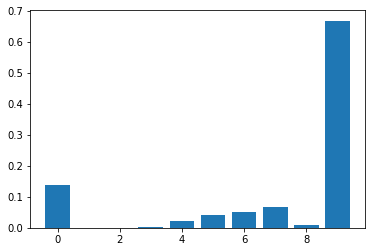

validation accuracy = 0.6159, f1 score = 0.2489
	!! Best Model Save !!



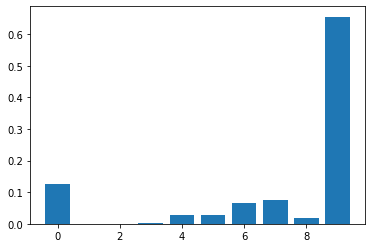

validation accuracy = 0.6147, f1 score = 0.2504
	!! Best Model Save !!


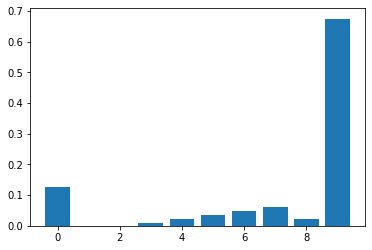

validation accuracy = 0.6154, f1 score = 0.2535
	!! Best Model Save !!


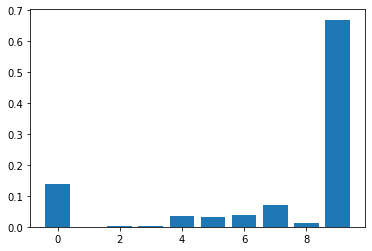

validation accuracy = 0.6155, f1 score = 0.2442


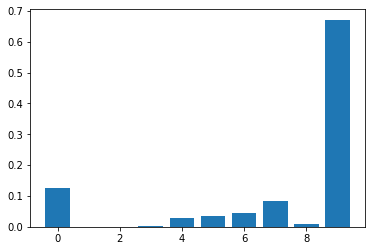

validation accuracy = 0.6163, f1 score = 0.2519


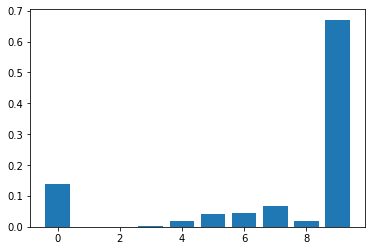

validation accuracy = 0.6204, f1 score = 0.2548
	!! Best Model Save !!



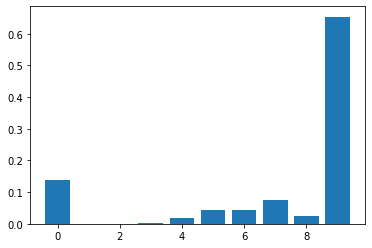

validation accuracy = 0.6158, f1 score = 0.2512


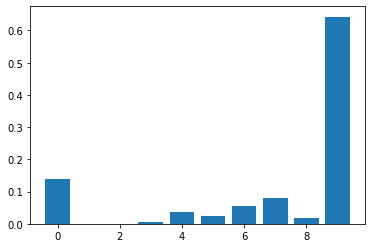

validation accuracy = 0.6130, f1 score = 0.2561
	!! Best Model Save !!


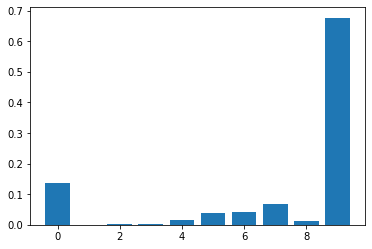

validation accuracy = 0.6170, f1 score = 0.2411


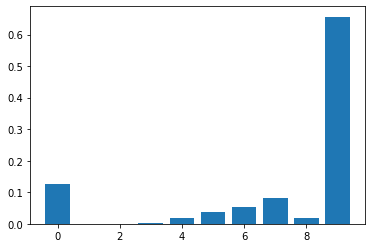

validation accuracy = 0.6143, f1 score = 0.2548


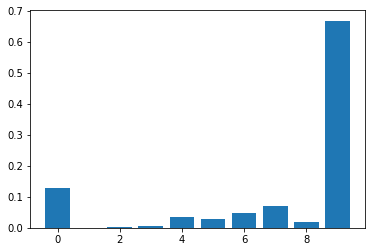

validation accuracy = 0.6152, f1 score = 0.2549



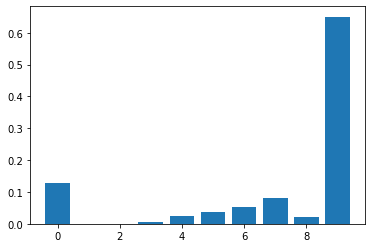

validation accuracy = 0.6139, f1 score = 0.2587
	!! Best Model Save !!


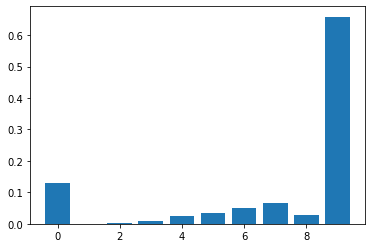

validation accuracy = 0.6149, f1 score = 0.2614
	!! Best Model Save !!


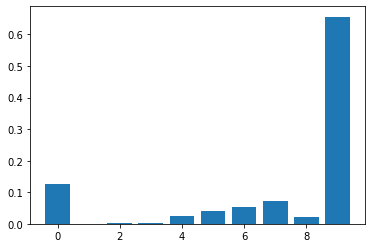

validation accuracy = 0.6145, f1 score = 0.2587


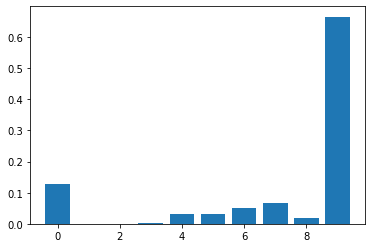

validation accuracy = 0.6150, f1 score = 0.2543


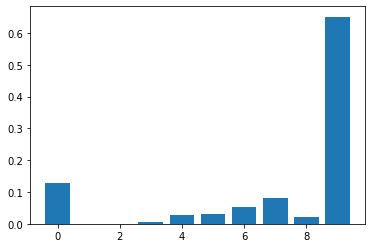

validation accuracy = 0.6139, f1 score = 0.2590


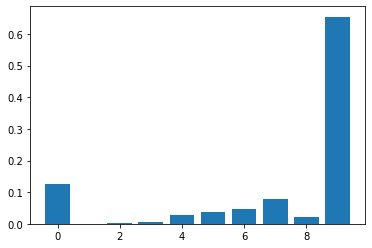

validation accuracy = 0.6137, f1 score = 0.2606
Best Accuracy: 0.6148663101604278 / Best F1 score: 0.2613640977275827 in epoch 7
Best model load!



Training with 7 started


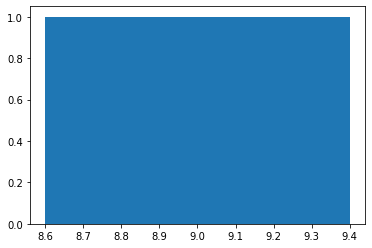

validation accuracy = 0.5201, f1 score = 0.0684
	!! Best Model Save !!


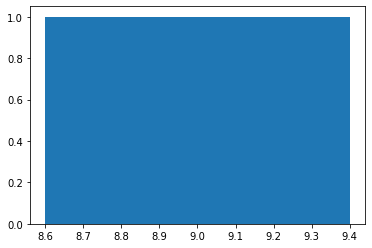

validation accuracy = 0.5201, f1 score = 0.0684


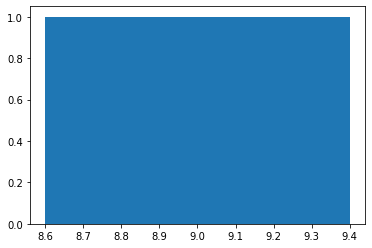

validation accuracy = 0.5201, f1 score = 0.0684


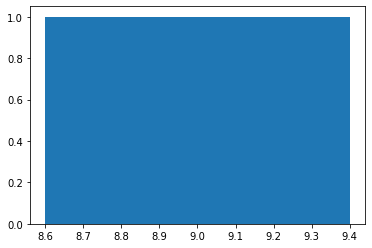

validation accuracy = 0.5201, f1 score = 0.0684


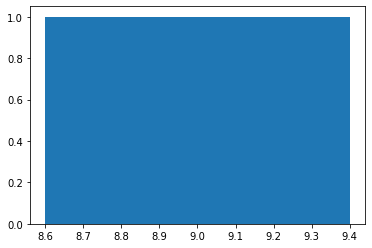

validation accuracy = 0.5201, f1 score = 0.0684
Best Accuracy: 0.5200556209220237 / Best F1 score: 0.06842586728590529 in epoch 0
Best model load!



Training with 8 started


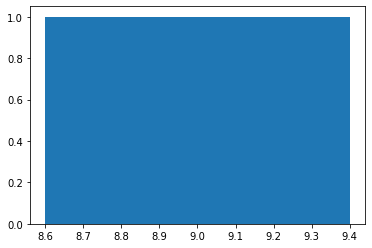

validation accuracy = 0.5201, f1 score = 0.0684
	!! Best Model Save !!


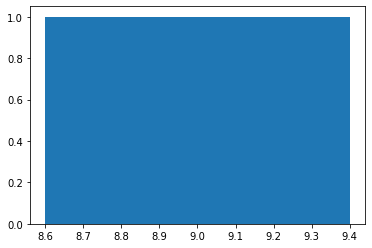

validation accuracy = 0.5201, f1 score = 0.0684


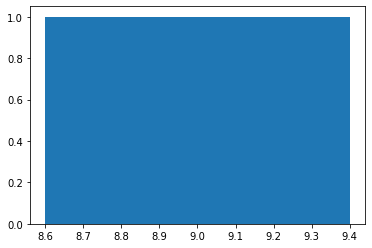

validation accuracy = 0.5201, f1 score = 0.0684


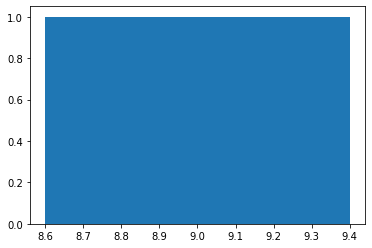

validation accuracy = 0.5201, f1 score = 0.0684


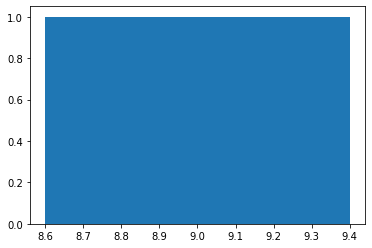

validation accuracy = 0.5201, f1 score = 0.0684
Best Accuracy: 0.5200556209220237 / Best F1 score: 0.06842586728590529 in epoch 0
Best model load!



Training with 9 started


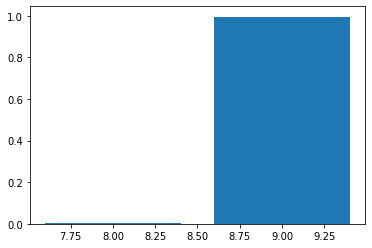

validation accuracy = 0.5187, f1 score = 0.0688
	!! Best Model Save !!


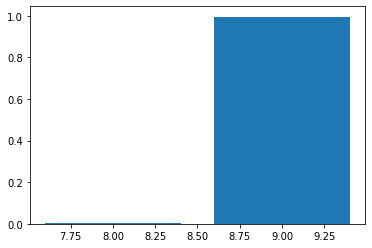

validation accuracy = 0.5187, f1 score = 0.0688


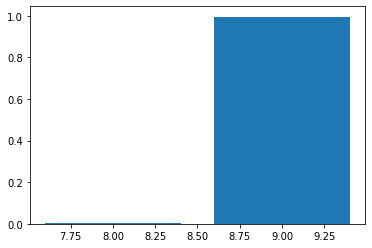

validation accuracy = 0.5187, f1 score = 0.0688


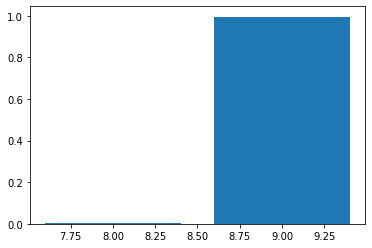

validation accuracy = 0.5187, f1 score = 0.0688


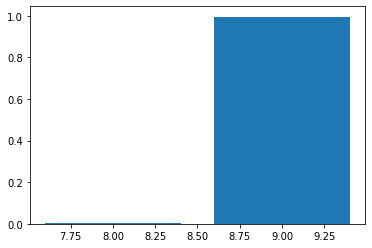

validation accuracy = 0.5187, f1 score = 0.0688
Best Accuracy: 0.5186650978714301 / Best F1 score: 0.06880121253465017 in epoch 0
Best model load!


In [ ]:
if CFG.mode == 'kfold':
    fold_num = 10

    all_df = pd.concat([train_df, valid_df], ignore_index=True)

    test_dataset = TestDataset(test_df, tokenizer)

    test_loader = DataLoader(
        test_dataset,
        batch_size=CFG.batch_size,
        shuffle=False
    )

    seed_everything(CFG.seed)

    oof_pred = None
    initial_model_wts = copy.deepcopy(model.cpu().state_dict())

    # label별 분포를 고려하여 10개의 fold로 나누어 학습
    kfold = StratifiedKFold(n_splits=fold_num)
    for fold , (train_index, valid_index) in enumerate(kfold.split(all_df, all_df["label"])):
        print('Training with {} started'.format(fold))
        
        train_df = all_df.loc[train_index]
        valid_df = all_df.loc[valid_index]
        
        train_df = train_df.reset_index(drop=True)
        valid_df = valid_df.reset_index(drop=True)

        train_ds = NLPDataset(train_df, tokenizer, threshold=0)
        valid_ds = NLPDataset(valid_df, tokenizer)
        
        # imbalanced_sampler = ImbalancedDatasetSampler(train_ds)

        train_loader = DataLoader(
            train_ds,
            batch_size=CFG.batch_size,
            pin_memory=True,
            drop_last=False,
            shuffle=True,
            # sampler=imbalanced_sampler,
            # num_workers=CFG.num_workers,
        )

        val_loader = DataLoader(
            valid_ds,
            batch_size=CFG.batch_size,
            pin_memory=True,
            shuffle=False,
            # num_workers=CFG.num_workers,
        )

        best_accuracy = 0
        best_f1 = 0
        best_epoch = 0
        stop_count = 0
        global_step = 0

        model.load_state_dict(initial_model_wts)
        for epoch in range(CFG.epoch):
            
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for step, batch in pbar:
                global_step += 1
                label = batch[-1]
                with autocast():
                    # training
                    model.to(CFG.device).train()
                    batch = tuple(t.to(CFG.device) for t in batch[:-1])

                    if 'xlm-roberta' in CFG.model:
                        outputs = model(input_ids=batch[0],
                                        attention_mask=batch[1])[0]
                    else:
                        outputs = model(input_ids=batch[0],
                                        attention_mask=batch[1],
                                        token_type_ids=batch[2],
                                        return_dict=False)[0]
                    
                    preds = torch.argmax(outputs, 1).detach().cpu().numpy()
                    
                    loss = loss_fn(outputs, label.to(CFG.device))
                    scaler.scale(loss).backward()
                    
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()

                    if scheduler is not None:
                        scheduler.step()

                    accuracy = (preds==label.detach().cpu().numpy()).mean()
                    f1 = f1_score(preds, label.detach().cpu().numpy(), average='macro')
                    
                    description = f'global_step-{global_step} loss: {loss.item():.4f} acc: {accuracy:.4f} f1: {f1:.4f}'
                    pbar.set_description(description)
                    
                if (global_step + 1) % 500 == 0:
                    with torch.no_grad():
                        epoch_accuracy, epoch_f1 = valid_one_epoch(epoch, model, loss_fn, val_loader, CFG.device)
                    
                    if epoch_f1 > best_f1:
                        stop_count = 0
                        best_state_dict = copy.deepcopy(model.cpu().state_dict())
                        
                        best_accuracy = epoch_accuracy
                        best_f1 = epoch_f1
                        best_epoch = epoch

                        print('\t!! Best Model Save !!')
                    else:
                        # early stopping
                        stop_count += 1
                if stop_count > 3:
                    break
            if stop_count > 3:
                break

        print('Best Accuracy: {} / Best F1 score: {} in epoch {}'.format(best_accuracy, best_f1, best_epoch))

        # 저장되어 있는 best model을 load 해옵니다.
        model.cpu().load_state_dict(best_state_dict)
        # torch.save(model.state_dict(), f'{cfg.save_path}/best_model.pt')
        print('Best model load!')
        
        # 각 fold에서 생성된 모델을 사용해 Test 데이터를 예측합니다.
        all_predictions = []
        with torch.no_grad():
            model.to(CFG.device).eval()
            for batch in tqdm(test_loader):
                data_id = batch[-1]
                batch = tuple(t.to(CFG.device) for t in batch[:-1])

                if 'xlm-roberta' in CFG.model:
                    pred = model(input_ids=batch[0],
                                    attention_mask=batch[1])[0]
                else:
                    pred = model(input_ids=batch[0],
                                    attention_mask=batch[1],
                                    token_type_ids=batch[2],
                                    return_dict=False)[0]
                all_predictions.extend(pred.cpu().numpy())
        
        fold_pred = np.array(all_predictions)
        if oof_pred is None:
            oof_pred = softmax(fold_pred, axis=1)
        else:
            oof_pred += softmax(fold_pred, axis=1)

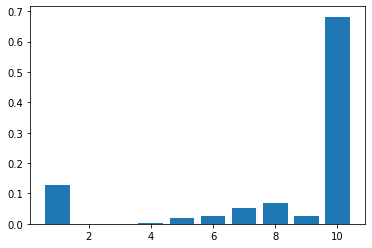

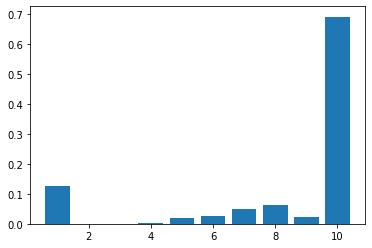

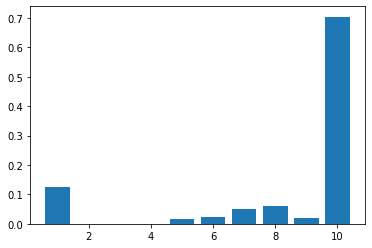

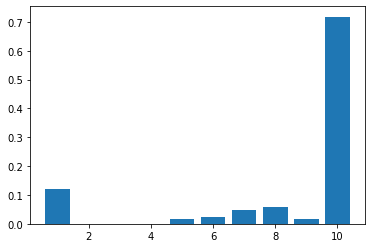

In [ ]:
if CFG.mode == 'kfold':
    all_result = copy.deepcopy(oof_pred)

    all_result = np.argmax(all_result, axis=1)

    all_result[test_zero_id_list] = 9
    all_result += 1

    label_counter = Counter(all_result.tolist())
    class_hist(label_counter)

    submission = pd.read_csv(cfg.submission_path)
    submission['Prediction'] = all_result
    submission.to_csv(f'{cfg.save_result_path}/all_result_36.csv', index = None)

###################################################################################

    all_weight_result = copy.deepcopy(oof_pred)
    all_weight_result[:,-1] += 0.1

    all_weight_result = np.argmax(all_weight_result, axis=1)

    all_weight_result[test_zero_id_list] = 9
    all_weight_result += 1

    label_counter = Counter(all_weight_result.tolist())
    class_hist(label_counter)

    submission = pd.read_csv(cfg.submission_path)
    submission['Prediction'] = all_weight_result
    submission.to_csv(f'{cfg.save_result_path}/all_weight_result_37.csv', index = None)

###################################################################################

    all_weight_result = copy.deepcopy(oof_pred)
    all_weight_result[:,-1] += 0.2

    all_weight_result = np.argmax(all_weight_result, axis=1)

    all_weight_result[test_zero_id_list] = 9
    all_weight_result += 1

    label_counter = Counter(all_weight_result.tolist())
    class_hist(label_counter)

    submission = pd.read_csv(cfg.submission_path)
    submission['Prediction'] = all_weight_result
    submission.to_csv(f'{cfg.save_result_path}/all_weight_result_38.csv', index = None)

###################################################################################

    all_weight_result = copy.deepcopy(oof_pred)
    all_weight_result[:,-1] += 0.3

    all_weight_result = np.argmax(all_weight_result, axis=1)

    all_weight_result[test_zero_id_list] = 9
    all_weight_result += 1

    label_counter = Counter(all_weight_result.tolist())
    class_hist(label_counter)

    submission = pd.read_csv(cfg.submission_path)
    submission['Prediction'] = all_weight_result
    submission.to_csv(f'{cfg.save_result_path}/all_weight_result_39.csv', index = None)